In [1]:
using Pkg
Pkg.activate(".")
using LinearNoiseApproximation # need to import package from Julia to have LNA() function work
using DifferentialEquations
using Catalyst
using Reexport
using ModelingToolkit
using DiffEqBase
using JumpProcesses
using Plots
include("utils.jl") # need to import this utility file locally for LNA helper functions to work

using DifferentialEquations.EnsembleAnalysis
using Symbolics
using LinearAlgebra
using RowEchelon
using Statistics

  Activating project at `~/Documents/EMRE Julia Package`


In [2]:
## go through each reaction and adjust parameters to make units 1/t, i.e. multiply 0 --> X reactions by volume and divide biomolecular ones by volume, check if biomolecular reaction is same-species and if so multiply by 2
function adjustParams(rn::ReactionSystem, params, volume)

    systemParams = rn.ps
    systemReactions = rn.rxs
    
    adjustedTF = falses(length(systemParams))

    adjustedParams = copy(Float64.(params))

    for reaction in systemReactions
        if length(reaction.substrates) == 0 ## check if it's a zero order reaction
            paramIndex = findfirst(x->isequal(x,reaction.rate), systemParams) ## if it is, find what number parameter it is
            if !adjustedTF[paramIndex] ## if it hasn't already been adjusted
                adjustedParams[paramIndex] = adjustedParams[paramIndex]*volume ## multiply by volume
                adjustedTF[paramIndex] = true ## mark that it was adjusted
            end
        end
        if length(reaction.substrates) == 2 ## check if it's a biomolecular reaction
            paramIndex = findfirst(x->isequal(x,reaction.rate), systemParams) ## if it is, find what number parameter it is
            if !adjustedTF[paramIndex] ## if it hasn't already been adjusted
                adjustedParams[paramIndex] = adjustedParams[paramIndex]/volume ## divide by volume
                adjustedTF[paramIndex] = true
            end
        end
        if (length(reaction.substrates) == 1) && (reaction.substoich[1] == 2) ## check if it's a biomolecular reaction with same-species
            paramIndex = findfirst(x->isequal(x,reaction.rate), systemParams) ## if it is, find what number parameter it is
            if !adjustedTF[paramIndex] ## if it hasn't already been adjusted
                adjustedParams[paramIndex] = adjustedParams[paramIndex] * (2/volume) ## if it is, multiplay rate by 2/volume
                adjustedTF[paramIndex] = true ## mark that it's been adjusted
            end
        end
    end

    return adjustedParams
end;


In [3]:
## will set up the paramaters to pass to the LNA functions and the SSA functions

function setParams(rn::ReactionSystem, params, volume)

    LNAparams = params;
    SSAparams = adjustParams(rn, params, volume) ## needs to know which rates are involved in biomolecular reactions as well as which ones need to be adjusted for units

    return LNAparams, SSAparams
end;

In [4]:
function runSSA(rn::ReactionSystem, ics, params, volume, tEnd, numSteps, numTrajs)

    tSpan = (0.0, tEnd); ## make time span
    timePoints = LinRange(0, tEnd, numSteps); ## set up time points to calculate SSA means at
    
    ## set up and run ensemble problem
    jumpsys = convert(JumpSystem, rn);
    dprob = DiscreteProblem(jumpsys, ics, tSpan, params);
    jprob = JumpProblem(jumpsys, dprob, Direct(), save_positions=(false, false));
    eprob = EnsembleProblem(jprob) 

    jsol = solve(eprob, SSAStepper(), trajectories = numTrajs, saveat = tEnd/(numSteps-1));

    means = timepoint_mean(jsol, timePoints)/volume; ## caclulate mean concentrations through time

    return timePoints, means
end;

In [5]:
function runLNA(rn::ReactionSystem, ics, params, volume, tEnd, numSteps)

    tSpan = (0.0, tEnd); ## set up time span

    ## set up and solve LNA problem from LinearNoiseApproximation.jl package
    lna = LNASystem(rn);
    prob = ODEProblem(lna, ics/volume, tSpan, params); ## CHANGED ICS TO PUT IN CONCENTRATIONS
    sol = solve(prob, Vern7(), saveat = tEnd/(numSteps-1));

    ## get indices of means and variances for each species in system
    meanIdxs, varIdxs = find_states_cov_number(collect(1:length(rn.species)), lna);
    
    return meanIdxs, varIdxs, sol

end;

In [6]:
function buildDeltaVect(rn::ReactionSystem, params, meanIdxs, varIdxs, LNAsol)

    deltaVec = zeros(length(rn.species))
        
    for reaction in rn.rxs
            
        if length(reaction.substrates) == 2 ## if a biomolecular reaction of different species

            species1idx = findfirst(x->isequal(x,reaction.substrates[1]), rn.species) ## find first species
            species2idx = findfirst(x->isequal(x,reaction.substrates[2]), rn.species) ## find second species

            covIdx = varIdxs[min(species1idx, species2idx)] + (max(species1idx, species2idx) - min(species1idx, species2idx)) ## find index of covariance, e.g. species 5 & 3 gives varIdxs[3] (which is variance of s3) + 2
            cov = LNAsol[covIdx, end] ## get covariance in SS (can change later to be in time)

            rateParamIdx = findfirst(x->isequal(x, reaction.rate), rn.ps) ## find what parameter is the rate 
            rate = params[rateParamIdx] ## get numerical rate from parameters
            
            adjustment = rate*cov ## k*<e_i,e_j>

            ## subtract the adjustment term from the two reactants
            deltaVec[species1idx] -= adjustment
            deltaVec[species2idx] -= adjustment
            
            for species in reaction.products ## for each product made in reaction

                prodIdx = findfirst(x->isequal(x,species),reaction.products) ## see what index it is in product list
                numProduced = reaction.prodstoich[prodIdx] ## see how many are produced by reaction

                speciesIdx = findfirst(x->isequal(x, species), rn.species) ## find index in the system species
                deltaVec[speciesIdx] += numProduced * adjustment ## add adjustment term for each one produced (??)
            end
        end

        if length(reaction.substrates) == 1 && (reaction.substoich[1] == 2) ## if it's a biomolecular reaction with the same species
                
            speciesIdx = findfirst(x->isequal(x, reaction.substrates[1]), rn.species) ## find what species it is

            ## find indices of its mean and variance
            meanIdx = meanIdxs[speciesIdx]
            varIdx = varIdxs[speciesIdx] 
            mean = LNAsol[meanIdx, end] ## SS mean (can change later to be in time)
            var = LNAsol[varIdx, end] ## SS var (can change later to be in time)

            rateParamIdx = findfirst(x->isequal(x, reaction.rate), rn.ps) ## find what parameter is the rate 
            rate = params[rateParamIdx] ## get numerical rate from parameters

            adjustment = rate * (var - mean) ## k * [<e_i^2> - phi_i]

            deltaVec[speciesIdx] -= 2 * adjustment ## subtract 2 * the adjustment from the reactants

            for species in reaction.products

                prodIdx = findfirst(x->isequal(x,species),reaction.products) ## see what index it is in product list
                numProduced = reaction.prodstoich[prodIdx] ## see how many are produced by reaction

                speciesIdx = findfirst(x->isequal(x, species), rn.species) ## find index in the system species
                deltaVec[speciesIdx] += numProduced * adjustment ## add adjustment term for each one produced (??)
            end
        end
    end

    return deltaVec
end;

In [7]:
function getInvJac(rn::ReactionSystem, params, meanIdxs, LNAsol, reducedSpecies = nothing, reducedSystem = nothing)

    if reducedSpecies != nothing && reducedSystem != nothing

        jacMat = calculate_jacobian(reducedSystem)
        subDict = Dict([])

        for species in reducedSpecies
            speciesIdx = findfirst(x->isequal(x, species), rn.species) ## get index
            subDict[species] = LNAsol[meanIdxs[speciesIdx],end] ## if species shows up in Jacobian, substitute its steady state value)
        end
        for param in rn.ps ## for each parameter in the system
            paramIdx = findfirst(x->isequal(x,param), rn.ps) ## get index
            subDict[param] = params[paramIdx] ## if parameter shows up in Jacobian, substitute the numerically value supplied
        end
        
        jacMatNumerical = substitute(jacMat, subDict) ## sub in numerical values into Jacobian
        jacMatInv = inv(jacMatNumerical) ## get inverse of Jacobian

    else
        sys = convert(ODESystem, rn, combinatoric_ratelaws=false); ## convert reactioin system to ODE system
        jacMat = calculate_jacobian(sys); ## get the Jacobian
        
        subDict = Dict([]) ## initialize dictionary for substituting variables and steady states
        for species in rn.species ## for each species in the system
            speciesIdx = findfirst(x->isequal(x, species), rn.species) ## get index
            subDict[species] = LNAsol[meanIdxs[speciesIdx],end] ## if species shows up in Jacobian, substitute its steady state value
        end
        for param in rn.ps ## for each parameter in the system
            paramIdx = findfirst(x->isequal(x,param), rn.ps) ## get index
            subDict[param] = params[paramIdx] ## if parameter shows up in Jacobian, substitute the numerically value supplied
        end
        
        jacMatNumerical = substitute(jacMat, subDict) ## sub in numerical values into Jacobian
        jacMatInv = inv(jacMatNumerical) ## get inverse of Jacobian
    end
    
    return jacMatInv
end;

In [8]:
function getRealizedVector(rn::ReactionSystem, params, meanIdxs, varIdxs, LNAsol, volume, conservationLaws = nothing)

    SS = zeros(length(rn.species)) ## initialize vector for deterministic steady states
    for species in rn.species ## for each species
        speciesIdx = findfirst(x->isequal(x, species), rn.species) ## find index in system
        SS[speciesIdx] = LNAsol[meanIdxs[speciesIdx], end] ## record steady state value
    end

    deltaVec = buildDeltaVect(rn, params, meanIdxs, varIdxs, LNAsol) ## get delta vector with adjustments

    if conservationLaws != nothing ## if there's conservation conservationLaws
        reducedSpecies, reducedSystem = buildNewDESystem(rn, conservationLaws)
        
        invJac = getInvJac(rn, params, meanIdxs, LNAsol, reducedSpecies, reducedSystem) 
        
        deltaVecReduced = [deltaVec[findfirst(x->isequal(x, species), rn.species)] for species in reducedSpecies]
   
        realizedSS = zeros(length(rn.species))
        subDict = Dict([])
        i = 1
        for species in reducedSpecies
            speciesIdx = findfirst(x->isequal(x, species), rn.species)
            realizedSS[speciesIdx] = SS[speciesIdx] - ( (1/volume)*invJac*deltaVecReduced )[i] 
            subDict[species] = realizedSS[speciesIdx]
            i += 1
        end

        for law in conservationLaws
            speciesToCompute = findfirst(x->isequal(x, law.lhs), rn.species)
            realizedSS[speciesToCompute] = substitute(law.rhs, subDict)
        end

    else ## getting Jacobian and realized vector normally
        invJac = getInvJac(rn, params, meanIdxs, LNAsol) ## get inverse Jacobian
        realizedSS = SS - (1/volume)*invJac*deltaVec ## Eq. 26 from 2009 paper
    end
    
    return SS, realizedSS
end;

In [9]:
function buildNewDESystem(rn::ReactionSystem, conservationLaws)
    
    sys = convert(ODESystem, rn, combinatoric_ratelaws = false)
    indicesToRemove = []
    subDict = Dict([])
    for law in conservationLaws
        index = findfirst(x->isequal(x, law.lhs), rn.species)
        push!(indicesToRemove, index)
        subDict[rn.species[index]] = law.rhs
    end

    reducedSystem = []
    reducedSpecies = []
    for i in 1:length(rn.species)
        if i in indicesToRemove
            continue
        end
        push!(reducedSystem,sys.eqs[i])
        push!(reducedSpecies, rn.species[i])
    end

    @named newSystem = ODESystem([substitute(eq, subDict) for eq in reducedSystem])
    
    return reducedSpecies, newSystem
end;

In [10]:
function EMRE(rn::ReactionSystem, ics, params, volume, tEnd, numSteps, numTrajs, conservationLaws = nothing)

   LNAparams, SSAparams = setParams(rn, params, volume)
   
   timePoints, SSAmeans = runSSA(rn, ics, SSAparams, volume, tEnd, numSteps, numTrajs)
   meanIdxs, varIdxs, LNAsol = runLNA(rn, ics, LNAparams, volume, tEnd, numSteps)
   
   SS, realizedSS = getRealizedVector(rn, LNAparams, meanIdxs, varIdxs, LNAsol, volume, conservationLaws)
   
   return timePoints, SSAmeans, SS, realizedSS
end;

# TESTING #

Example A from paper

In [11]:
X1_0 = 2; X2_0 = 40; ## define ics for each species
k1Param = 1000; k2Param = 100; k3Param = 10; ## define parameter values for all rates

tEnd = 10; ## run time
numSteps = 101; ## number of points to save SSA at
numTrajs = 1000; ## how many trajectories o use for SSA

ics = [X1_0, X2_0]; ## initial conditions for species in the order they are defined in the ReactionSystem
params = [k1Param, k2Param, k3Param]; ## parameter values for rates in the order they are defined in the ReactionSystem
volume = 3; ## volume of the system

rn = @reaction_network begin ## reaction network
    @species X1(t) X2(t)
    @parameters k1 k2 k3
    k1, 1*X1 <-- 0
    k2, X1+X1 --> X2
    k3, X1 --> 0
    k3, X2 --> 0
end;

In [15]:
timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);
println(SS[1])

2.211207727381336


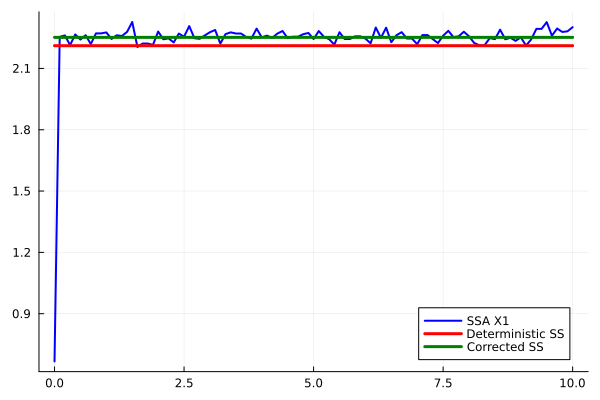

In [16]:
## plotting species 1

plot(timePoints, [array[1] for array in SSAmeans], color="blue", lw=2, label="SSA X1")
plot!([0, tEnd], [SS[1], SS[1]], color="red", lw=3, label = "Deterministic SS")
plot!([0, tEnd], [realizedSS[1], realizedSS[1]], color="green", lw=3, label="Corrected SS")#, ylim=(2,3))

Example B from paper

In [57]:
X1_0 = 0; X2_0 = 0; X3_0 = 0; ## define ics for each species
k1Param = 500; k2Param = 40; k3Param = 50; ## define parameter values for all rates

tEnd = 10; ## run time
numSteps = 101; ## number of points to save SSA at
numTrajs = 1000; ## how many trajectories o use for SSA

ics = [X1_0, X2_0, X3_0]; ## initial conditions for species in the order they are defined in the ReactionSystem
params = [k1Param, k2Param, k3Param]; ## parameter values for rates in the order they are defined in the ReactionSystem
volume = 1; ## volume of the system

rn = @reaction_network begin ## reaction network
    @species X1(t) X2(t) X3(t)
    @parameters k1 k2 k3
    k1, 0 --> 2*X1
    k1, 0 --> 2*X2 
    k2, X1+X2 --> X3
    k3, X1 --> 0
    k3, X2 --> 0
    k3, X3 --> 0
end;

In [58]:
timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);

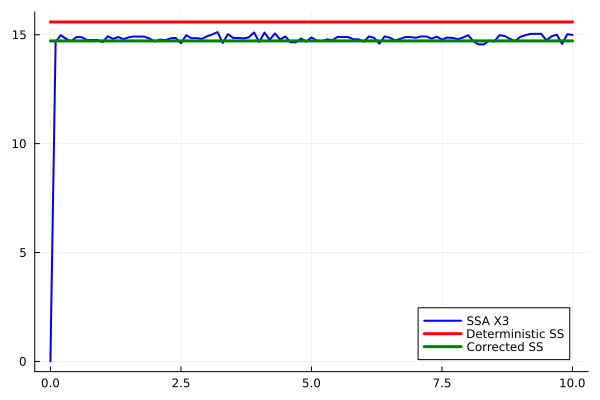

In [60]:
## plotting species 1

plot(timePoints, [array[3] for array in SSAmeans], color="blue", lw=2, label="SSA X3")
plot!([0, tEnd], [SS[3], SS[3]], color="red", lw=3, label = "Deterministic SS")
plot!([0, tEnd], [realizedSS[3], realizedSS[3]], color="green", lw=3, label="Corrected SS")#,ylim=(15,16))

## Simple Conservation Law Example ##

In [11]:


rn = @reaction_network begin
    @species A(t) B(t) C(t)
    @parameters k1 k2
    (k1, k2), A+B<-->C
end
display(rn)
display(convert(ODESystem,rn))
ics = [4, 3, 1]
params = [0.2, 0.5]
volume = 2; tEnd = 80; numSteps = 101; numTrajs = 10000;
conservationEqs = [rn.species[1]~(ics[1]+ics[3])/volume-rn.species[3], rn.species[2]~(ics[2]+ics[3])/volume-rn.species[3]]
display(conservationEqs)



Model ##ReactionSystem#231
States (3):
  A(t)
  B(t)
  C(t)
Parameters (2):
  k1
  k2

Model ##ReactionSystem#231 with 3 equations
States (3):
  A(t)
  B(t)
  C(t)
Parameters (2):
  k1
  k2

2-element Vector{Equation}:
 A(t) ~ 2.5 - C(t)
 B(t) ~ 2.0 - C(t)

In [13]:
timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs, conservationEqs);
display(SS)

3-element Vector{Float64}:
 1.692582403567252
 1.192582403567252
 0.8074175964327481

In [24]:
display(mean(SSAmeans[3,:]))
display(realizedSS[3])

0.8389717821782179

0.8422200640249651

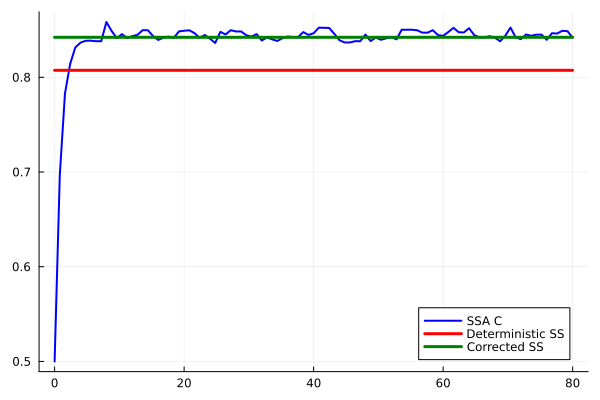

In [42]:
plot(timePoints, [array[3] for array in SSAmeans], color="blue", lw=2, label="SSA C")
plot!([0, tEnd], [SS[3], SS[3]], color="red", lw=3, label = "Deterministic SS")
plot!([0, tEnd], [realizedSS[3], realizedSS[3]], color="green", lw=3, label="Corrected SS")

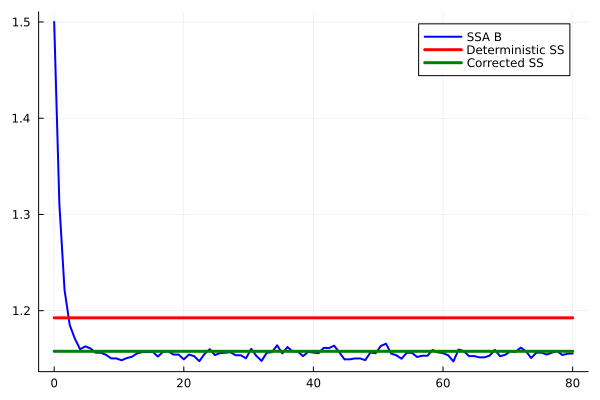

In [32]:
plot(timePoints, [array[2] for array in SSAmeans], color="blue", lw=2, label="SSA B")
plot!([0, tEnd], [SS[2], SS[2]], color="red", lw=3, label = "Deterministic SS")
plot!([0, tEnd], [realizedSS[2], realizedSS[2]], color="green", lw=3, label="Corrected SS")

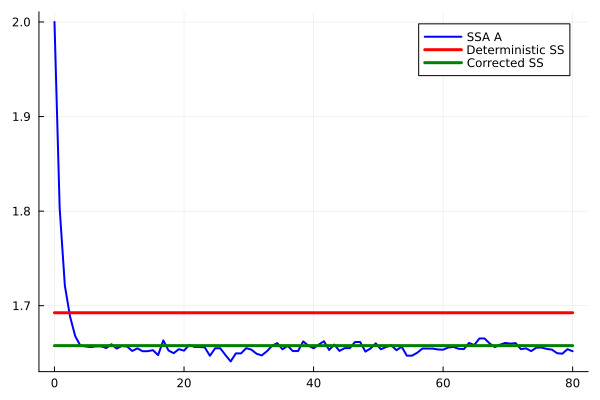

In [27]:
plot(timePoints, [array[1] for array in SSAmeans], color="blue", lw=2, label="SSA A")
plot!([0, tEnd], [SS[1], SS[1]], color="red", lw=3, label = "Deterministic SS")
plot!([0, tEnd], [realizedSS[1], realizedSS[1]], color="green", lw=3, label="Corrected SS")